May: Bathymetry of Mackenzie Canyon as depicted by the IBCAO_V3_500m_RR and IBCAO_V3_30arcsec_RR.

In [1]:
import  numpy as np
import  os
import  scipy as sc, scipy.io
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from    pyproj import Proj, Geod, transform
import  cartopy.crs as ccrs
import  matplotlib.cm as cm
import colormap_ibcao
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Two options for Arctic grid

#### Stereographic: IBCAO_V3_500m_RR

* GMT_version: 4.5.8
* dimensions(sizes): x(11617), y(11617)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
* float64 x(x), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float64 y(y), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float32 z(y, x), actual_range: [-5573.01660156  5921.39746094], current shape = (11617, 11617)
* polar stereographic projection

#### Geographic: IBCAO_V3_30arcsec_RR

* GMT_version: 4.5.8 [64-bit]
* dimensions(sizes): x(43201), y(3121)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
* Geographic Coordinate System

# Functions created for this notebook

In [2]:
def get_variables(projection):
    ''' Loads the file for either the Stereographic 
    or Geographic projection of the Arctic Ocean 
    (IBCAO) and returns the file's data for x, y,
    and z. This data can be plotted using the 
    functions below.
    
    Stereographic projection IBCAO_V3_500m_RR.
    Geographic projection IBCAO_V3_30arcsec_RR.
    '''
    if projection == 'S':
        ibcao_grid_name = 'IBCAO_V3_500m_RR.grd'
    elif projection == 'G':
        ibcao_grid_name = 'IBCAO_V3_30arcsec_RR.grd'
    ibcao_grid_dir = '/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid'
    ibcao_grid = os.path.join(ibcao_grid_dir, ibcao_grid_name)
    ibcao_nc = scipy.io.netcdf_file (ibcao_grid)

    x = ibcao_nc.variables['x'][:]
    y = ibcao_nc.variables['y'][:]
    z = ibcao_nc.variables['z'][:]
    return x, y, z

#--------------------------------------------------------------------------------------

def return_boundariesS(x, y, z, xl, xr, yb, yt, case):
    ''' Uses the x, y, and z values from get_variables
    which represent the entire Arctic bathymetry 
    available and extracts a specified region given
    xleft, xright, ybottom, and ytop or a pre-arranged
    case. It returns the xn, yn, and zn of the region.

    Stereographic projection IBCAO_V3_500m_RR.
    '''
    if case == 'region':
        xl=-1800000; xr=-700000; yb=1200000; yt=2000000
    elif case == 'canyon':
        xl=-1600000; xr=-1350000; yb=1560000; yt=1730000
    elif case == 'HS':
        xl=-1630000; xr=-1470000; yb=1580000; yt=1710000
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(x==xl)[0][0]
    xmax = np.where(x==xr)[0][0]
    ymin = np.where(y==yb)[0][0]
    ymax = np.where(y==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

#--------------------------------------------------------------------------------------

def return_boundariesG(x, y, z, xl, xr, yb, yt, case):
    ''' Uses the x, y, and z values from get_variables
    which represent the entire Arctic bathymetry 
    available and extracts a specified region given
    xleft, xright, ybottom, and ytop or a pre-arranged
    case. It returns the xn, yn, and zn of the region.
    
    Geographic projection IBCAO_V3_30arcsec_RR.
    '''
    if case == 'region':
        xl=-145; xr=-133; yb=68.6; yt=72.5
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(np.round(x,2)==xl)[0][0]
    xmax = np.where(np.round(x,2)==xr)[0][0]
    ymin = np.where(np.round(y,2)==yb)[0][0]
    ymax = np.where(np.round(y,2)==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

#--------------------------------------------------------------------------------------

def plot_mackenzie(fig, ax, xn, yn, zn, plot_type, lines):
    ''' Uses the xn, yn, zn of a reduced region of the 
    Arctic defined by either return_boundaries functions
    and plots the area defined, as pcolor, contour, or 3D.
    '''
    (cmap, norm) = colormap_ibcao.Colormap()
    if plot_type == 'full':
        c = ax.pcolorfast(xn,yn,zn,cmap=cmap)
        fig.colorbar(c)
    if plot_type == 'contour':
        cs = ax.contour(xn,yn,zn,lines,linewidths=2,cmap=cmap)
        ax.clabel(cs, inline=1, fontsize=10)
        cb = fig.colorbar(cs, shrink=0.7)
        for line in cb.lines: 
           line.set_linewidth(12)
        ax.xaxis.tick_top()
    if plot_type=='surface':
        Xn, Yn = np.meshgrid(xn, yn)
        surf = ax.plot_surface(Xn, Yn, zn, cmap=cmap, linewidth=0, rstride=1, cstride=1, antialiased=False)
        fig.colorbar(surf, shrink=0.5)
    return fig, ax

#--------------------------------------------------------------------------------------

def get_information(ax, point, name):
    ''' Labels specific points defined by their
    coordinates with the depth in that region
    and the point's name.
    '''
    x_point = point[0]
    y_point = point[1]
    ax.plot(x_point, y_point, 'ko', markersize=6)
    depth = np.round(z[np.where(y==y_point), np.where(x==x_point)][0][0],2)
    ax.text(x_point, y_point, name + str(depth), fontsize=12)
    return ax

#--------------------------------------------------------------------------------------

def find_points_diagonal(x1, y1, x2, slope):
    '''Finds coordinates along any line in the
    stereographic projection given point 1 (x1, y1),
    the x2 of point 2, and the slope of the line.
    x2 needs to be bigger(rightward).
    '''
    list_x = np.arange(x1, x2 + 500, 500)
    list_y = np.zeros_like(list_x)
    list_y[:] = (slope * (list_x[:] - x1)) + y1
    list_y[:] = np.round(list_y[:]/500.0)*500.0
    return list_x, list_y

#--------------------------------------------------------------------------------------

def find_distance(p_one, p_two):
    ''' Finds the distance between two points.
    This is used to find the various canyon
    dimensions, such as widths and cross and along
    shore distances.
    '''
    xmax = abs(p_one[0])
    xmin = abs(p_two[0])
    ymax = p_one[1]
    ymin = p_two[1]
    dist = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
    return dist

#--------------------------------------------------------------------------------------

def match_distance(p1_x, p1_y, p2_x, m_slope, ideal):
    ''' Use a reference point [p1_x, p1_y] and the 
    slope of the line to find the second point
    [p2_x, p2_y]. dist gives the length of the line. 
    The goal is to realistic distances found here
    with those set in the idealized canyon domain.
    The ideal case would be for dist = dim leading
    to diff_dist ~ 0.
    '''
    p2_y = p1_y + (m_slope * (p2_x - p1_x))
    dist = find_distance([p1_x, p1_y], [p2_x, p2_y])
    diff = ideal - dist
    return p2_y, dist, diff

#--------------------------------------------------------------------------------------

def match_lines(p1_x, p1_y, p2_x_iterate, m_slope, ideal):
    '''This function searches for the stereographic coordinate
    which would create the line of the length required in 
    order to match with the corresponding side of the 
    idealized domain. p1_x and p1_y are the coordinates
    for the the point p1 where the line begines. m_slope is
    the slope of the line, p2_x_iterate is the coordinates
    through which the function iterates to find the one where
    the resulting line length is closes to the the value of 
    ideal which is the dimension of the idealized domain.
    '''
    for x_i in p2_x_iterate:
        y_i, dist_i, diff_i = match_distance(p1_x, p1_y, x_i, m_slope, ideal)
        if abs(diff_i) < 300.0:
            p2_x = x_i
            p2_y = y_i
            p2_dist = dist_i
            p2_diff = diff_i
        else:
            pass
    return p2_x, p2_y, p2_dist, p2_diff

#--------------------------------------------------------------------------------------

def convert_corners(proj_from, proj_to, corner_lons, corner_lats):
    ''' Converts the coordinates of the domain corner points
    from the projection proj_from to the projection proj_to.
    The tranformed coordinates are returned.
    '''
    transformed_lons = []
    transformed_lats = []
    for i in np.arange(4):
        transformed_x, transformed_y = transform(proj_from, proj_to, corner_lons[i], corner_lats[i])
        transformed_lons.append(transformed_x)
        transformed_lats.append(transformed_y)

    return transformed_lons, transformed_lats

# Mackenzie Canyon dimensions

This map is used to find the dimensions of the canyon. I did this by defining the coordinates of the different key points for the deep ocean, base, break, mouth, mid-canyon, head, coast, and wall. The resolution is 500 m, which is why the coordinates of any of the points are only defined up to the minimum 500 m. The width was found using lines perpendicular to the axis line, given a known x. Once the right points were found given their depths (such as 80 m), the y2 was rounded to the nearest 500 m.

These dimensions are used in make_mackenzie.ipynb and make_coordinates.ipynb to create the idealized bathymetry and domain.

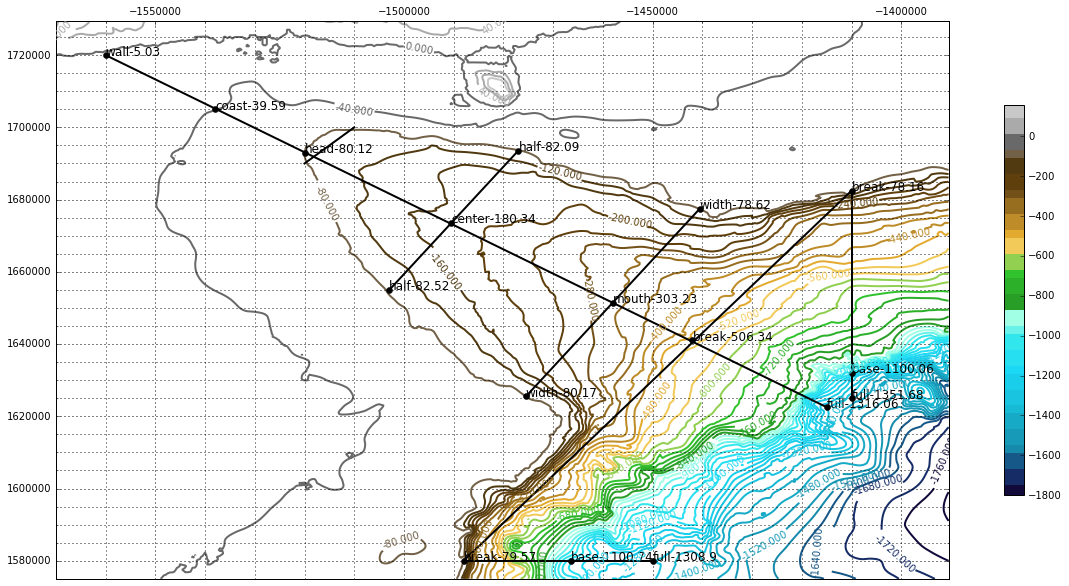

In [3]:
x, y, z = get_variables('S')
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
xl=-1570000; xr=-1390000; yb=1575000; yt=1730000
xn, yn, zn = return_boundariesS(x, y, z, xl, xr, yb, yt, None)
fig, ax = plot_mackenzie(fig, ax, xn, yn, zn, 'contour', 50)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=1.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.9)

# key points used to find canyon dimensions

bkL = [-1488000, 1580000]
fL = [-1450000, 1580000]
bsL = [-1466500, 1580000]
bkR = [-1410000, 1682500]
fR = [-1410000, 1625000]
bsR = [-1410000, 1632000]
bkC = [-1442000, 1641000]
p_top = [-1560000, 1720000]
p_bottom = [-1415000, 1622500]
hL = [-1520000, 1690000]
hR = [-1510000, 1700000]
wlC = [-1560000, 1720000]
cC = [-1490500, 1673500]
fC = [-1415000, 1622500] 
cst = [-1538000, 1705000]
hC = [-1520000, 1693000]
mC = [-1458000, 1651500]

# Lines used to visualize the locations of points and eventually calculate the distance between them
# slope - left
ax.plot([bkL[0], fL[0]], [bkL[1], fL[1]], 'k', linewidth=2)
get_information(ax, bkL, 'break') 
get_information(ax, fL, 'full') 
get_information(ax, bsL, 'base') 

# slope - right
ax.plot([bkR[0], fR[0]], [bkR[1], fR[1]], 'k', linewidth=2)
get_information(ax, bkR, 'break') 
get_information(ax, fR, 'full')
get_information(ax, bsR, 'base') 

# along shelf break
ax.plot([bkR[0], bkL[0]], [bkR[1], bkL[1]], 'k', linewidth=2)
get_information(ax, bkC, 'break')

# inner head
ax.plot([hL[0], hR[0]], [hL[1], hR[1]], 'k', linewidth=2);

# along canyon axis
ax.plot([p_top[0], p_bottom[0]], [p_top[1], p_bottom[1]], 'k', linewidth=2)
get_information(ax, wlC, 'wall') 
get_information(ax, fC, 'full')
get_information(ax, cst, 'coast') 
get_information(ax, hC, 'head')
get_information(ax, mC, 'mouth')
get_information(ax, cC, 'center')

# slope of the canyon axis line and the perpendicular line
m_axis = (p_top[1] - p_bottom[1])/(p_top[0] - p_bottom[0])
m_pend = -1/m_axis 

# canyon widths (at mid-length and mouth)
x1 = cC[0]; y1 = cC[1]
x2 = -1477000
y2 = y1 + (m_pend * (x2 - x1))
w2R = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2)
get_information(ax, w2R, 'half')

x2 = -1503000
y2 = y1 + (m_pend * (x2 - x1))
w2L = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2) 
get_information(ax, w2L, 'half')

x1 = mC[0]; y1 = mC[1]
x2 = -1440500
y2 = y1 + (m_pend * (x2 - x1))
wfR = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2)
get_information(ax, wfR, 'width')

x2 = -1475500
y2 = y1 + (m_pend * (x2 - x1))
wfL = [x2, round(y2/500.0)*500.0]
ax.plot([x1, x2], [y1, y2], 'k', linewidth=2)
get_information(ax, wfL, 'width')

# calculate the distances
base_left = find_distance(fL, bsL)
base_right = find_distance(fR, bsR)
break_left = find_distance(fL, bkL)
break_right = find_distance(fR, bkR)
coast = find_distance(fC, cst)
wall = find_distance(fC, wlC)
mouth = find_distance(fC, mC)
length = find_distance(mC, hC)
width_f = find_distance(wfR, wfL)
width_2 = find_distance(w2R, w2L)
width_h = find_distance(hR, hL)
Rcurv = find_distance(mC, cC)
length_new_dist = find_distance(bkC, hC)
length_new = find_distance(fC, bkC)


# Additional Mackenzie Canyon features

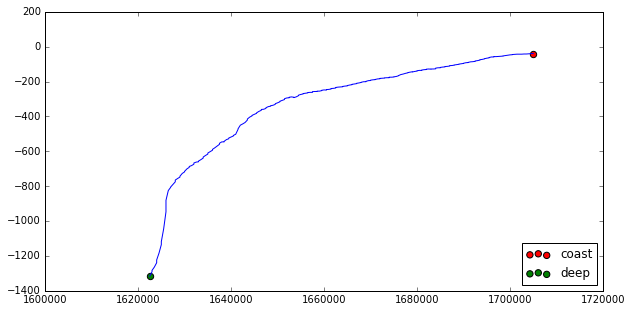

In [4]:
x1 = cst[0]
y1 = cst[1]
x2 = fC[0]
y2 = fC[1]

z1 = z[np.where(y==y1), np.where(x==x1)][0][0]
z2 = z[np.where(y==y2), np.where(x==x2)][0][0]

slope = (y2 - y1) / (x2 - x1)
list_x, list_y = find_points_diagonal(x1, y1, x2, slope)
list_z = np.zeros_like(list_x)
for i in np.arange(len(list_x)):
    list_z[i] = z[np.where(y==list_y[i]), np.where(x==list_x[i])][0][0]

fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax.plot(list_y, list_z)
ax.scatter(y1, z1, label='coast', c='r', s=40); ax.scatter(y2, z2, label='deep', c='g', s=40); ax.legend(loc=4)

# Outline of model domain

In [5]:
def match_domain(this_slope, x_wall, y_wall, p2_x0, p2_y0, search_x, ax):
    '''This is the main function used to create the realistic domain.
    It uses match_lines to create each section of the rectangle.
    It makes the right angle corners and the sides are as close
    as possible to the size of the idealized domain. The key here
    is to define the slope of the domain (the angle of the sides),
    the length and width of the idealized domain, and the initial
    reference point p2_x0 and p2_y0. They were called p2 because
    they were originally the second point in the line running
    along the axis of the canyon. This function also plots the
    lines. Search_x is the range of x coordinates that will be
    iterated through in order to find the one that produces the
    line length closest to the ideal size. The -500 is used
    when iterating leftward and 500 for rightward.'''
    
    #search_x = [-1250000, -1500000, -1600000, -1700000, -1400000, -1300000] original

    # All the slopes needed to make the perpendicular corners
    m_slope = np.zeros(6)
    m_slope[0] = this_slope; m_slope[1] = -1/this_slope; m_slope[2] = this_slope
    m_slope[3] = this_slope; m_slope[4] = -1/this_slope; m_slope[5] = this_slope

    # The values of the sides of the idealized domain
    ideal = np.zeros(6)
    ideal[0] = x_wall/2; ideal[1] = y_wall; ideal[2] = x_wall/2
    ideal[3] = x_wall/2; ideal[4] = y_wall; ideal[5] = x_wall/2

    # Line segments making up the domain # Location of second point p2 that completes the line with given p1
    lw=1.5; n=0; p1_x = p2_x0; p1_y = p2_y0 # Bottom Right
    p2_xBR, p2_yBR, distBR, diffBR = match_lines(p1_x, p1_y, np.arange(p1_x, search_x[n], 500), m_slope[n], ideal[n])
    ax.plot([p1_x, p2_xBR], [p1_y, p2_yBR], 'k', linewidth=lw) 

    n=1; p1_x = p2_xBR; p1_y = p2_yBR # Top Right
    p2_xTR, p2_yTR, distTR, diffTR = match_lines(p1_x, p1_y, np.arange(p1_x, search_x[n], -500), m_slope[n], ideal[n])
    ax.plot([p1_x, p2_xTR], [p1_y, p2_yTR], 'k', linewidth=lw) 

    n=2; p1_x = p2_xTR; p1_y = p2_yTR # Top Centre
    p2_xTC, p2_yTC, distTC, diffTC = match_lines(p1_x, p1_y, np.arange(p1_x, search_x[n], -500), m_slope[n], ideal[n])
    ax.plot([p1_x, p2_xTC], [p1_y, p2_yTC], 'k', linewidth=lw) 

    n=3; p1_x = p2_xTC; p1_y = p2_yTC # Top Left
    p2_xTL, p2_yTL, distTL, diffTL = match_lines(p1_x, p1_y, np.arange(p1_x, search_x[n], -500), m_slope[n], ideal[n])
    ax.plot([p1_x, p2_xTL], [p1_y, p2_yTL], 'k', linewidth=lw) 

    n=4; p1_x = p2_xTL; p1_y = p2_yTL # Bottom Left
    p2_xBL, p2_yBL, distBL, diffBL = match_lines(p1_x, p1_y, np.arange(p1_x, search_x[n], 500), m_slope[n], ideal[n])
    ax.plot([p1_x, p2_xBL], [p1_y, p2_yBL], 'k', linewidth=lw) 

    n=5; p1_x = p2_xBL; p1_y = p2_yBL #Bottom Centre
    p2_xBC, p2_yBC, distBC, diffBC = match_lines(p1_x, p1_y, np.arange(p1_x, search_x[n], 500), m_slope[n], ideal[n])
    ax.plot([p1_x, p2_xBC], [p1_y, p2_yBC], 'k', linewidth=lw) 
    
    p2_BR = [round(p2_xBR/500.0)*500.0, round(p2_yBR/500.0)*500.0]
    p2_TR = [round(p2_xTR/500.0)*500.0, round(p2_yTR/500.0)*500.0]
    p2_TL = [round(p2_xTL/500.0)*500.0, round(p2_yTL/500.0)*500.0]
    p2_BL = [round(p2_xBL/500.0)*500.0, round(p2_yBL/500.0)*500.0]
    
    return p2_BR, p2_TR, p2_TL, p2_BL, ax

This map is used to match the domains of the real and idealized canyon bathymetries. The first section just plots the region that will hold the domain. The function *match_lines* is used to create the sides of the domain given a reference point. This reference point can either be hand-picked:

    p2_x0 = value
    p2_y0 = value

or it can be determined by another point, such as the wall point:

    p1_x0 = p_top[0] # wall x
    p1_y0 = p_top[1] # wall y
    # I found this p2_x0 manually and chose it because it resulted in a line with p1 whose length was
    # equal to the cross-shore distance of the idealized domain. The line moves along the canyon axis.
    p2_x0 = value 
    m_slope = m_axis
    ideal = y_wall
    p2_y0, dist0, diff0 = match_distance(p1_x0, p1_y0, p2_x0, m_slope, ideal)

It depends on whether you already have an idealized length in mind or if you know which realistic region you want. In the case below, I decided what reference point to choose based on how much of the shelf and slope was contained in the domain. Next, the slope *this_slope* is chosen. Here, I adjusted the slope until both sides of the shelf were crossing the y-sides and the x-side was more or less parallel to the shelf break. In order to find the point at the right distance for the right slope, the code scans through a range of coordinates defined by search_x. The dimensions of the region, defined by *x_wall* and *y_wall* need to be consistent with those found in make_mackenzie.ipynb. Finally, the code finds precise points that may not exist in the actual map because of the 500 m resolution. So, the domain boundaries are plotted outside of the function (in code below) so that we can be sure of what the rounded values look like on the map.

[-1162500.0, 1672000.0] [-1403000.0, 1891000.0] [-1698000.0, 1566500.0] [-1457500.0, 1348000.0]


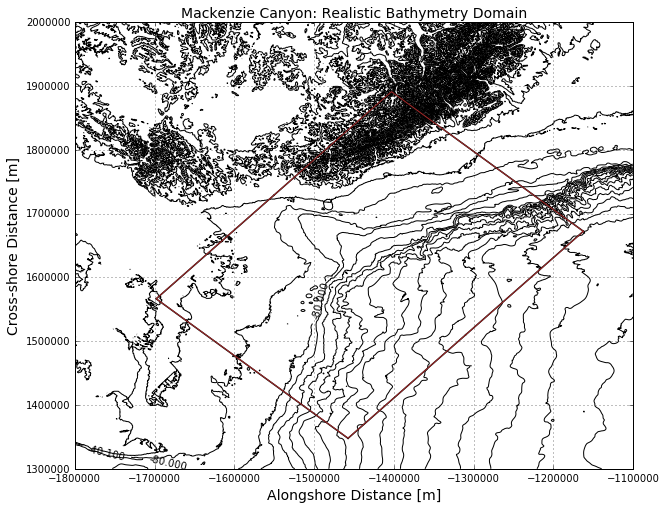

In [6]:
x, y, z = get_variables('S')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xl=-1800000; xr=-1100000; yb=1300000; yt=2000000
xn, yn, zn = return_boundariesS(x, y, z, xl, xr, yb, yt, None)
ax.contour(xn, yn, zn, 25, colors='k', linestyles='solid')
#CS = ax.contour(xn, yn, zn, levels = [-3200, -1300, -80, -40.1, 0, 2000], colors='r', linestyles='-')
CS = ax.contour(xn, yn, zn, levels = [-80, -40.1], colors='k', linestyles='-')
ax.clabel(CS, inline=1); ax.grid(); lw=1
# -----------------------
this_slope = 1.1
x_wall = width_f * 7 
y_wall = (mouth + length) * 2.57
p2_x0 = -1310000 
p2_y0 = 1510000
search_x = [-1100000, -1450000, -1600000, -1750000, -1400000, -1290000]
# -----------------------
#ax.scatter(p2_x0, p2_y0, s=50, c='k')
#ax.scatter(-1560000, 1720000, s=50, c='k')
p2_BR, p2_TR, p2_TL, p2_BL, ax = match_domain(this_slope, x_wall, y_wall, p2_x0, p2_y0, search_x, ax)
ax.plot([p2_BR[0], p2_TR[0], p2_TL[0], p2_BL[0], p2_BR[0]], [p2_BR[1], p2_TR[1], p2_TL[1], p2_BL[1], p2_BR[1]], 'brown')
ax.set_title('Mackenzie Canyon: Realistic Bathymetry Domain', fontsize=14)
ax.set_xlabel('Alongshore Distance [m]', fontsize=14); ax.set_ylabel('Cross-shore Distance [m]', fontsize=14)
print(p2_BR, p2_TR, p2_TL, p2_BL)
fig.savefig('seminar2.png', format='png', dpi=500, facecolor=fig.get_facecolor(), transparent=True)

The values of **p2_BR, p2_TR, p2_TL, p2_BL** are then used to create a grid on SeaGrid and then the resulting file is run through the Compute_ScalingFactors.m script that generates the complete and final coordinates file. More details about this process can be found on make_coordinates.ipynb.

In [7]:
corner_lons = []
corner_lats = []
corner_all = [p2_BR, p2_TR, p2_TL, p2_BL]
for i in np.arange(len(corner_all)):
    corner_lons.append(corner_all[i][0])
    corner_lats.append(corner_all[i][1])
corner_lons, corner_lats

([-1162500.0, -1403000.0, -1698000.0, -1457500.0],
 [1672000.0, 1891000.0, 1566500.0, 1348000.0])

# Convert coordinates

[Example 1](http://geoinformaticstutorial.blogspot.ca/2014/06/converting-coordinates-between-map.html)
[Example 2](http://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/)

The Proj class can convert from geographic (longitude,latitude) to native map projection (x,y) coordinates and vice versa, or from one map projection coordinate system directly to another. Coordinate system changes are done with the transform function. The easiest way is to find the EPSG code for your projections. Alternatively you can use the Proj.4 definition.

Find the EPSG code at https://epsg.io/. The website even has a transform option too. 
* EPSG:3996 IBCAO Polar Stereographic [m]
* EPSG:3995 Arctic Polar Stereographic [m]
* mercator, stereographic, and geographic are only available in metres. (?)
* EPSG:3857 Spherical Mercator projection (popular on google)

In [13]:
proj_stereographic = Proj("+init=EPSG:3996")
proj_mercator = Proj("+init=EPSG:3857")

mercator_lons, mercator_lats = convert_corners(proj_stereographic, proj_mercator, corner_lons, corner_lats)
print(mercator_lons, mercator_lats)

[-16162484.858722195, -15966217.157493852, -14771347.121310925, -14779315.830306431] [11612457.44608148, 10685682.373428976, 10807231.234267352, 11774709.439976461]
